# Model Training - AAPL Stock Price Prediction

Objetivo: Treinar modelo Prophet para prever preços de fechamento da AAPL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Coletar Dados Novamente (Fresh)

Vamos coletar dados direto do Yahoo Finance para evitar problemas com CSV

In [3]:
import yfinance as yf
from datetime import timedelta

ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Coletando dados de {ticker}...")
stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

print(f"✓ {len(stock_data)} registros coletados")
stock_data.head()

Coletando dados de AAPL...


[*********************100%***********************]  1 of 1 completed

✓ 1254 registros coletados


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-10-29,112.173805,113.739881,109.138923,109.304291,146129200
2020-10-30,105.890060,108.934664,104.781163,108.030037,190272600
2020-11-02,105.802513,107.660408,104.392075,106.133241,122866900
2020-11-03,107.426956,108.448305,105.763610,106.668237,107624400
2020-11-04,111.813919,112.436458,109.284854,111.026020,138235500


## 2. Preparar Dados para Prophet

In [4]:
df = pd.DataFrame()
df['ds'] = stock_data.index
df['y'] = stock_data['Close'].values
df = df.reset_index(drop=True)

print(f"Dataset preparado: {len(df)} registros")
print(f"Período: {df['ds'].min().date()} até {df['ds'].max().date()}")
print(f"Preço médio: ${df['y'].mean():.2f}")
print(f"\nPrimeiras linhas:")
df.head()

Dataset preparado: 1254 registros
Período: 2020-10-29 até 2025-10-27
Preço médio: $174.19

Primeiras linhas:


,ds,y
0,2020-10-29,112.173805
1,2020-10-30,105.890060
2,2020-11-02,105.802513
3,2020-11-03,107.426956
4,2020-11-04,111.813919


## 3. Dividir em Treino e Teste

In [5]:
test_size = 90
train = df[:-test_size].copy()
test = df[-test_size:].copy()

print(f"Treino: {len(train)} registros ({train['ds'].min().date()} até {train['ds'].max().date()})")
print(f"Teste: {len(test)} registros ({test['ds'].min().date()} até {test['ds'].max().date()})")

Treino: 1164 registros (2020-10-29 até 2025-06-18)
Teste: 90 registros (2025-06-20 até 2025-10-27)


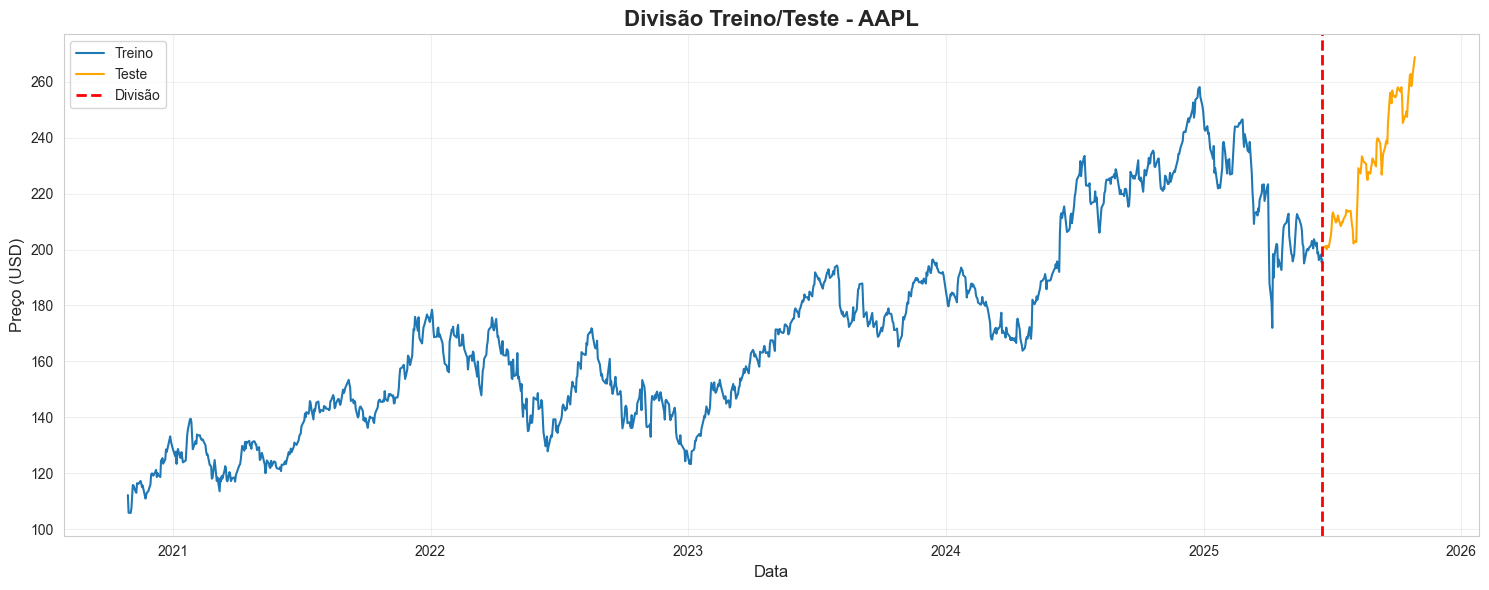

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Treino', linewidth=1.5)
plt.plot(test['ds'], test['y'], label='Teste', linewidth=1.5, color='orange')
plt.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', linewidth=2, label='Divisão')
plt.title('Divisão Treino/Teste - AAPL', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Treinar Modelo Prophet

In [7]:
print("Treinando modelo Prophet...")
start_time = datetime.now()

model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

model.fit(train)

training_time = (datetime.now() - start_time).total_seconds()
print(f"✓ Modelo treinado em {training_time:.2f} segundos")

Treinando modelo Prophet...


AttributeError: 'Prophet' object has no attribute 'stan_backend'

## 5. Fazer Previsões

In [ ]:
future = model.make_future_dataframe(periods=test_size, freq='D')
forecast = model.predict(future)

print(f"Previsões geradas: {len(forecast)}")
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

## 6. Avaliar Performance

In [ ]:
predictions = forecast[-test_size:]['yhat'].values
actuals = test['y'].values

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
r2 = r2_score(actuals, predictions)

print("="*60)
print("MÉTRICAS DE PERFORMANCE")
print("="*60)
print(f"MAE (Mean Absolute Error): ${mae:.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print("="*60)

mean_price = actuals.mean()
print(f"\nPreço médio no teste: ${mean_price:.2f}")
print(f"Erro representa {(mae/mean_price)*100:.2f}% do preço médio")

## 7. Visualizar Previsões vs Realidade

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test['ds'], actuals, label='Real', linewidth=2, marker='o', markersize=3)
plt.plot(test['ds'], predictions, label='Previsão', linewidth=2, linestyle='--', marker='x', markersize=3)
plt.title('Previsões vs Valores Reais - AAPL', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Gráfico Completo do Prophet

In [ ]:
fig = model.plot(forecast, figsize=(15, 6))
ax = fig.gca()
ax.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', linewidth=2, label='Divisão')
ax.set_title('Previsão Prophet - AAPL', fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Preço (USD)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Componentes da Série Temporal

In [ ]:
fig = model.plot_components(forecast, figsize=(15, 10))
plt.tight_layout()
plt.show()

## 10. Análise de Resíduos

In [ ]:
residuals = actuals - predictions

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(test['ds'], residuals, marker='o', linestyle='', alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Resíduos ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo (USD)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribuição dos Resíduos', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Resíduo (USD)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(predictions, actuals, alpha=0.6)
min_val = min(predictions.min(), actuals.min())
max_val = max(predictions.max(), actuals.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfeito')
axes[1, 0].set_title('Previsões vs Valores Reais', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Previsões (USD)')
axes[1, 0].set_ylabel('Valores Reais (USD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].scatter(predictions, residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Resíduos vs Previsões', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Previsões (USD)')
axes[1, 1].set_ylabel('Resíduos (USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Resíduo médio: ${residuals.mean():.2f}")
print(f"Desvio padrão: ${residuals.std():.2f}")

## 11. Previsão Futura (30 dias)

In [ ]:
future_days = 30
future_df = model.make_future_dataframe(periods=len(test) + future_days, freq='D')
future_forecast = model.predict(future_df)

future_only = future_forecast.tail(future_days)
print(f"Previsões para os próximos {future_days} dias:\n")
print(future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'], label='Histórico', linewidth=1.5, alpha=0.7)
plt.plot(future_only['ds'], future_only['yhat'], 
         label=f'Previsão {future_days} dias', linewidth=2, linestyle='--', color='red', marker='o', markersize=4)
plt.fill_between(future_only['ds'], future_only['yhat_lower'], future_only['yhat_upper'], 
                 alpha=0.3, color='red', label='Intervalo de Confiança')
plt.axvline(x=df['ds'].iloc[-1], color='green', linestyle='--', linewidth=2, label='Hoje')
plt.title(f'AAPL - Previsão {future_days} Dias', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Salvar Modelo

In [ ]:
import os

os.makedirs('../models', exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f'../models/prophet_aapl_{timestamp}.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✓ Modelo salvo: {model_path}")

## 13. Salvar Métricas

In [ ]:
import json

metrics = {
    'model': 'Prophet',
    'ticker': ticker,
    'timestamp': timestamp,
    'training_time_seconds': training_time,
    'train_size': len(train),
    'test_size': len(test),
    'mae': float(mae),
    'rmse': float(rmse),
    'mape': float(mape),
    'r2': float(r2),
    'model_file': model_path
}

metrics_path = f'../models/metrics_{timestamp}.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"✓ Métricas salvas: {metrics_path}")
print("\n" + json.dumps(metrics, indent=2))

## 14. Resumo Final

In [ ]:
print("="*70)
print("RESUMO DO TREINAMENTO")
print("="*70)
print(f"Ticker: {ticker}")
print(f"Modelo: Prophet")
print(f"Data de treino: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tempo de treino: {training_time:.2f}s")
print(f"\nDados:")
print(f"  Total: {len(df)} registros")
print(f"  Treino: {len(train)} ({train['ds'].min().date()} a {train['ds'].max().date()})")
print(f"  Teste: {len(test)} ({test['ds'].min().date()} a {test['ds'].max().date()})")
print(f"\nPerformance:")
print(f"  MAE: ${mae:.2f} ({(mae/mean_price)*100:.2f}%)")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²: {r2:.4f}")
print(f"\nArquivos:")
print(f"  Modelo: {model_path}")
print(f"  Métricas: {metrics_path}")
print("="*70)